In [2]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

cifar10_classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

affine = transforms.RandomAffine(degrees=(-30, 30), scale=(0.8, 1.2))
flip = transforms.RandomHorizontalFlip(p=0.5)
normalize = transforms.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0))

to_tensor = transforms.ToTensor()

transform_train = transforms.Compose([affine, flip, to_tensor, normalize])
transform_test = transforms.Compose([to_tensor, normalize])
cifar10_train = CIFAR10(
    root="./data", train=True, download=True, transform=transform_train
)
cifar10_test = CIFAR10(
    root="./data", train=False, download=True, transform=transform_test
)

# DataLoader의 설정
batch_size = 64
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import torch
import torch.nn as nn


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)  # 합성곱층(입력 채널 수, 필터 수, 필터 크기)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)  # 풀링층(영역의 크기, 영역의 간격)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 256)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


net = Net()
# net.cuda() # GPU로 전송
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
net.to(device)
print(net)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [4]:
from torch import optim

loss_fnc = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters())

record_loss_train = []
record_loss_test = []

for i in range(20):
    net.train()
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):
        x, t = x.to(device), t.to(device)
        # x, t = x.cuda(), t.cuda()
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j + 1
    record_loss_train.append(loss_train)

    net.eval()
    loss_test = 0
    for j, (x, t) in enumerate(test_loader):
        x, t = x.to(device), t.to(device)
        # x, t = x.cuda(), t.cuda()
        y = net(x)
        loss = loss_fnc(y, t)
        loss_test += loss.item()
    loss_test /= j + 1
    record_loss_test.append(loss_test)

    if i % 1 == 0:
        print(f"EPOCH: {i}, Loss(train): {loss_train}, Loss(test): {loss_test}")

EPOCH: 0, Loss(train): 1.8155918130484383, Loss(test): 1.5025604105299446
EPOCH: 1, Loss(train): 1.5816041680857957, Loss(test): 1.4076077201563841
EPOCH: 2, Loss(train): 1.510293127478236, Loss(test): 1.3462563639233827
EPOCH: 3, Loss(train): 1.464023309747886, Loss(test): 1.3253191003374234
EPOCH: 4, Loss(train): 1.4234465738696516, Loss(test): 1.2809859294040946
EPOCH: 5, Loss(train): 1.3976199351003409, Loss(test): 1.2285321453574356
EPOCH: 6, Loss(train): 1.375252105772038, Loss(test): 1.2127824444679698
EPOCH: 7, Loss(train): 1.3675976793479432, Loss(test): 1.1974977395337099
EPOCH: 8, Loss(train): 1.3584867903338673, Loss(test): 1.2007285808302035
EPOCH: 9, Loss(train): 1.3383608428413605, Loss(test): 1.1818101425079783
EPOCH: 10, Loss(train): 1.3313824798140075, Loss(test): 1.1698367819664584
EPOCH: 11, Loss(train): 1.3259127534868773, Loss(test): 1.1519792903760435
EPOCH: 12, Loss(train): 1.310716788558399, Loss(test): 1.1430409383621944
EPOCH: 13, Loss(train): 1.3089832652865

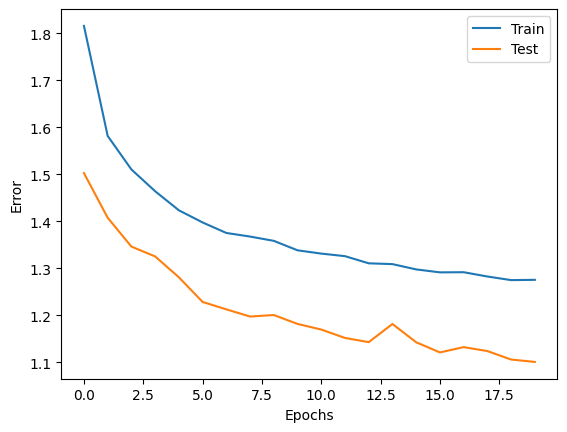

In [5]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

In [6]:
correct = 0
total = 0
net.eval()
for i, (x, t) in enumerate(test_loader):
    x, t = x.to(device), t.to(device)
    # x, t = x.cuda(), t.cuda()
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)

print("정답률: ", str(correct / total * 100) + "%")

정답률:  60.22%


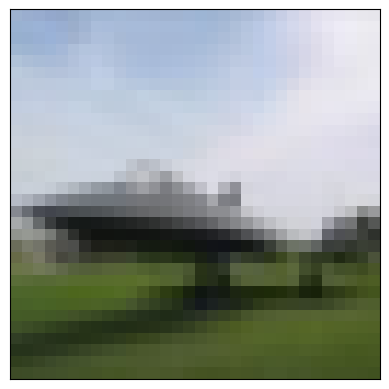

정답:  airplane 예측 결과:  airplane


In [8]:
cifar10_loader = DataLoader(cifar10_test, batch_size=1, shuffle=True)
dataiter = iter(cifar10_loader)
images, labels = next(dataiter)

plt.imshow(images[0].permute(1, 2, 0))
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
plt.show()

net.eval()
x, t = images.to(device), labels.to(device)
# x, t = images.cuda(), labels.cuda()
y = net(x)
print(
    "정답: ",
    cifar10_classes[labels[0]],
    "예측 결과: ",
    cifar10_classes[y.argmax().item()],
)